In [1]:
import mujoco
from pathlib import Path
import gym_lite6
import gymnasium as gym
import gym_lite6.env, gym_lite6.scripted_policy, gym_lite6.pickup_task
import mediapy as media
import numpy as np


/media/ssd/eugene/robotic_manipulation/lerobot_venv/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
model_path = Path(gym_lite6.__path__[0] + "/../models/lite6_gripper_wide.xml").resolve()
model_spec = mujoco.MjSpec.from_file(str(model_path))
target_spec = mujoco.MjSpec.from_file(str(model_path))

obj_path = gym_lite6.__path__[0] + "/../models/cube_pickup_large.xml"
obj_spec = mujoco.MjSpec.from_file(obj_path)

scene_path = gym_lite6.__path__[0] + "/../models/scene.xml"
scene_spec = mujoco.MjSpec.from_file(scene_path)

def print_bodies(parent, level=0):
  body = parent.first_body()
  while body:
    print(''.join(['-' for i in range(level)]) + '>' + body.name)
    print_bodies(body, level + 1)
    body = parent.next_body(body)

In [13]:
# This cell is just for inspecting the xml, no need to run
print("Bodies: ")
print_bodies(scene_spec.worldbody)
print("\nSites: ")
for site in scene_spec.sites:
  print(site.name)
print("\nActuators: ")
for actuator in scene_spec.actuators:
  print(actuator.name)
# for i in range(env.unwrapped.model.njnt):
#     print(f"{i} {env.unwrapped.model.jnt(i)}")

Bodies: 
>link_base
->link1
-->link2
--->link3
---->link4
----->link5
------>link6
------->gripper_body
-------->gripper_left_finger
-------->gripper_right_finger
>target
>box

Sites: 
attachment_site
end_effector
target

Actuators: 












gripper


In [5]:
frame = scene_spec.worldbody.add_frame()
frame.attach_body(model_spec.body("link_base"), "", "-1")
frame.attach_body(model_spec.body("target"), "", "-1")
# # frame.attach_body(obj_spec.worldbody, "", "-1")
# frame.attach_body(obj_spec.body("box"), "", "-1")
# frame.attach(model_spec)

ValueError: Error: incompatible id in mesh array, position 22
Element name 'link_base-1', id 0, line 44

In [4]:
frame = scene_spec.worldbody.add_frame()
frame.attach(model_spec)
frame.attach(obj_spec)

AttributeError: 'mujoco._specs.MjsFrame' object has no attribute 'attach'

In [9]:
frame.childclass

''

In [70]:
# inspection of scene spec
print([(i, s.name) for i, s in enumerate(scene_spec.bodies)])
for attr in dir(scene_spec.compiler):
    if not attr.startswith("__"):
        print(attr, getattr(scene_spec.compiler, attr))
for attr in dir(scene_spec.option):
    if not attr.startswith("__"):
        print(attr, getattr(scene_spec.option, attr))

[(0, 'world'), (1, 'link_base-1'), (2, 'box-1'), (3, 'link1-1'), (4, 'link2-1'), (5, 'link3-1'), (6, 'link4-1'), (7, 'link5-1'), (8, 'link6-1'), (9, 'gripper_body-1'), (10, 'gripper_left_finger-1'), (11, 'gripper_right_finger-1')]
LRopt <MjLROpt
  accel: 20.0
  interval: 2.0
  inttotal: 10.0
  maxforce: 0.0
  mode: 1
  timeconst: 1.0
  timestep: 0.01
  tolrange: 0.05
  useexisting: 1
  uselimit: 0
>
_pybind11_conduit_v1_ <bound method PyCapsule._pybind11_conduit_v1_ of <mujoco._specs.MjsCompiler object at 0xffff22ad40b0>>
alignfree 0
autolimits 1
balanceinertia 0
boundinertia 0.0
boundmass 0.0
degree 1
discardvisual 0
eulerseq <mujoco._specs.MjCharVec object at 0xffff211f9e30>
fitaabb 0
fusestatic 0
inertiafromgeom 2
inertiagrouprange [0 5]
settotalmass -1.0
usethread 1
_pybind11_conduit_v1_ <bound method PyCapsule._pybind11_conduit_v1_ of <mujoco._specs.MjOption object at 0xffff250a5330>>
apirate 100.0
ccd_iterations 50
ccd_tolerance 1e-06
cone 0
density 0.0
disableactuator 0
disablef

In [14]:
model = scene_spec.compile()
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)


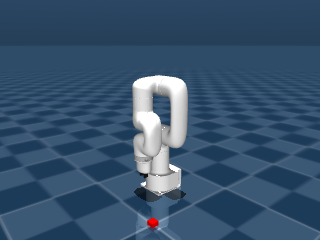

In [15]:
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.2
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)

mujoco.mj_forward(model, data)

renderer.update_scene(data, camera)
media.show_image(renderer.render())


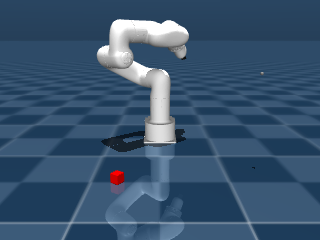

In [232]:
from importlib import reload

reload(gym_lite6.env)
reload(gym_lite6.utils)
reload(gym_lite6.scripted_policy)
reload(gym_lite6.pickup_task)

# task = gym_lite6.pickup_task.GraspTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')
task = gym_lite6.pickup_task.GraspAndLiftTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')

env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=500,
    visualization_width=320,
    visualization_height=240,
    render_fps=50,
    joint_noise_magnitude=0.1
)


observation, info = env.reset()
media.show_image(env.unwrapped.render(camera="side_cam"))


# 1: Create a dataset
TODO: combine action.qpos and action.gripper into just "action"

In [199]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.robot_devices.control_configs import RecordControlConfig
from PIL import Image

cfg = RecordControlConfig(
    repo_id="eufrizz/lite6_record_scripted_test",
    single_task="Pick up the block",
    root="datasets/lite6_record_scripted_test",
    fps=1/(int(1 / env.metadata["render_fps"] / env.unwrapped.model.opt.timestep)*env.unwrapped.model.opt.timestep), # the env is stepped at a higher rate than the renderer, sometimes they do not divide evenly
    video=True,
    # push_to_hub=False
)

""" pusht features
From pusht dataset:

{'observation.image': {'dtype': 'video',
  'shape': (96, 96, 3),
  'names': ['height', 'width', 'channel'],
  'video_info': {'video.fps': 10.0,
   'video.codec': 'av1',
   'video.pix_fmt': 'yuv420p',
   'video.is_depth_map': False,
   'has_audio': False}},
 'observation.state': {'dtype': 'float32',
  'shape': (2,),
  'names': {'motors': ['motor_0', 'motor_1']}},
 'action': {'dtype': 'float32',
  'shape': (2,),
  'names': {'motors': ['motor_0', 'motor_1']}},
 'episode_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'frame_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'timestamp': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'next.reward': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'next.done': {'dtype': 'bool', 'shape': (1,), 'names': None},
 'next.success': {'dtype': 'bool', 'shape': (1,), 'names': None},
 'index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'task_index': {'dtype': 'int64', 'shape': (1,), 'names': None}}
"""

features={'action': {'dtype': 'float32',
  'shape': (7,)},
 'observation.state.qpos': {'dtype': 'float32',
  'shape': (6,)},
 'observation.state.qvel': {'dtype': 'float32',
  'shape': (6,)},
  'observation.state.gripper': {'dtype': 'float32',
  'shape': (1,)},
 'observation.ee_pose.pos': {'dtype': 'float32',
  'shape': (3,)},
'observation.ee_pose.quat': {'dtype': 'float32',
  'shape': (4,)},
'observation.ee_pose.vel': {'dtype': 'float32',
  'shape': (3,)},
'observation.ee_pose.ang_vel': {'dtype': 'float32',
  'shape': (3,)},
 'observation.images.gripper': {'dtype': 'video',
  'shape': (240, 320, 3),
  'names': ['height', 'width', 'channels'],
  'info': None},
 'observation.images.side': {'dtype': 'video',
  'shape': (240, 320, 3),
  'names': ['height', 'width', 'channels'],
  'info': None},
   'episode_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'frame_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'timestamp': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'reward': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'task_index': {'dtype': 'int64', 'shape': (1,), 'names': None}}

dataset = LeRobotDataset.create(
    cfg.repo_id,
    cfg.fps,
    root=cfg.root,
    features=features,
    use_videos=cfg.video,
    image_writer_processes=0,
    image_writer_threads=1,
)

Planning with OMPL...
Info:    RRTstar: Space information setup was not yet called. Calling now.
Debug:   RRTstar: Planner range detected to be 4.681672
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 2.50 in 7 iterations (6 vertices in the graph)
OMPL path found!Info:    
RRTstar: Created 510 new states. Checked 130305 rewire options. 1 goal states in tree. Final solution cost 2.495
step=0 reward=0 terminated=False policy.stage=0
step=1 reward=0 terminated=False policy.stage=0
step=2 reward=0 terminated=False policy.stage=0
step=3 reward=0 terminated=False policy.stage=0
step=4 reward=0 terminated=False policy.stage=0
step=5 reward=0 terminated=False policy.stage=0
step=6 reward=0 terminated=False policy.stage=0
step

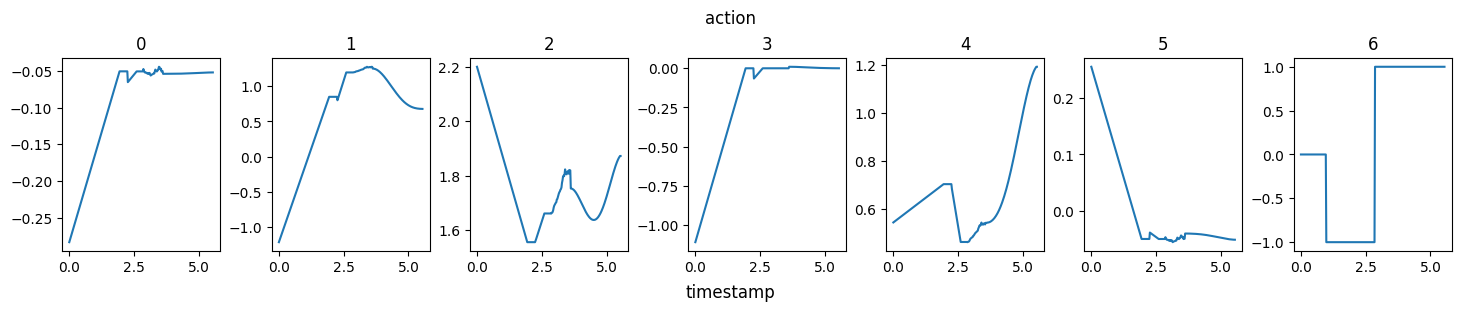

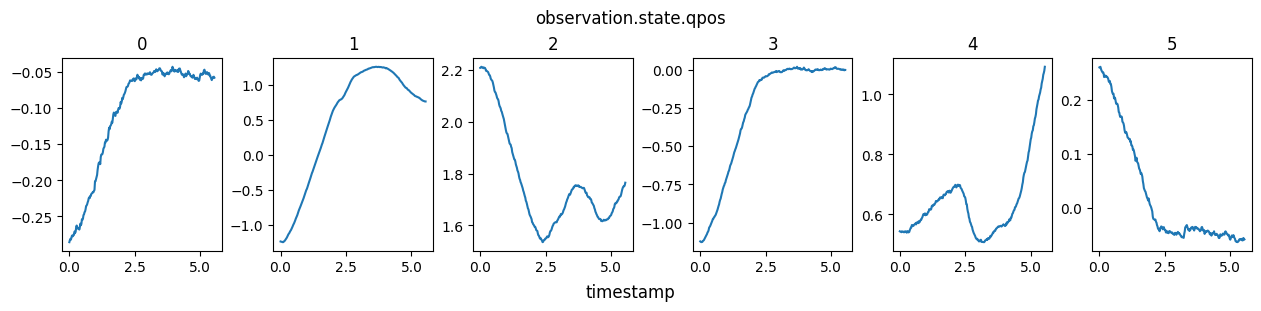

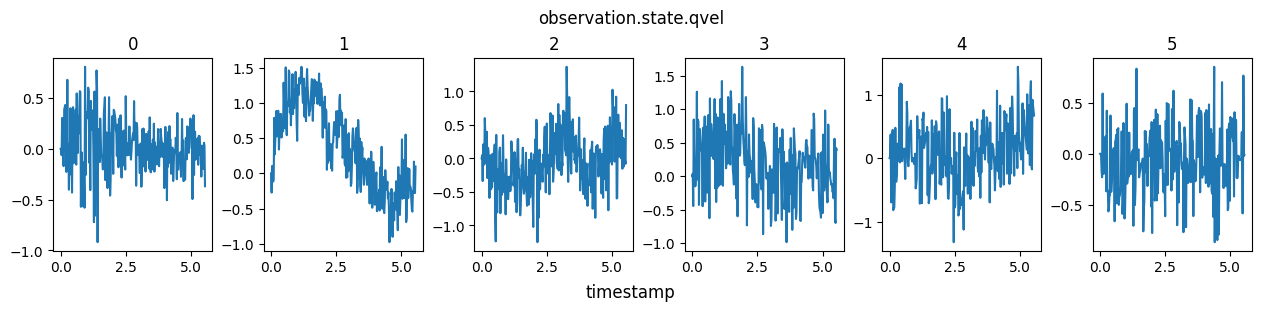

In [234]:
reload(gym_lite6.scripted_policy)
policy = gym_lite6.scripted_policy.GraspAndLiftPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.3)
policy.reset()
observation, info = env.reset(seed=69, qpos=None, box_pos=None, box_quat=None)

step = 0
reward = 0
done = False
# ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}
dataset.clear_episode_buffer()

while not done:
    # start_loop_t = time.perf_counter()

    action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)
    if action is None:
      obs_dict["observation.images.side"] = observation["pixels"]["side"]
      truncated = True
      break

    # delta = action["pos"] - observation["ee_pose"]["pos"]

    # # Quaternion error
    # quat_err = np.empty(4)
    # curr_quat = observation["ee_pose"]["quat"]
    # curr_quat_conj = np.empty(4)
    # ang_delta = np.empty(3)
    # mujoco.mju_negQuat(curr_quat_conj, curr_quat)
    # mujoco.mju_mulQuat(quat_err, action["quat"], curr_quat_conj)
    # mujoco.mju_quat2Vel(ang_delta, quat_err, 1.0)
    
    # # Convert to velocity (in world frame)
    # vel = Kp * delta * env.metadata["render_fps"]
    # ang_vel = Kp * ang_delta * env.metadata["render_fps"]
    # # Transform to end effector frame
    # action["qvel"] = env.unwrapped.solve_ik_vel(vel, ang_vel, ref_frame='end_effector', local=False)
    


    obs_dict = {'task': cfg.single_task}
    obs_dict["action"] = np.hstack([action["qpos"], action["gripper"]], dtype=np.float32)
    obs_dict["observation.state.qpos"] = np.array(observation["state"]["qpos"], dtype=np.float32)
    obs_dict["observation.state.qvel"] = np.array(observation["state"]["qvel"], dtype=np.float32)
    obs_dict["observation.state.gripper"] = np.array([observation["state"]["gripper"]], dtype=np.float32)
    obs_dict["observation.images.side"] = observation["pixels"]["side"]
    obs_dict["observation.images.gripper"] = observation["pixels"]["gripper"]
    obs_dict["observation.ee_pose.pos"] = np.array(observation["ee_pose"]["pos"], dtype=np.float32)
    obs_dict["observation.ee_pose.quat"] = np.array(observation["ee_pose"]["quat"], dtype=np.float32)
    obs_dict["observation.ee_pose.vel"] = np.array(observation["ee_pose"]["vel"], dtype=np.float32)
    obs_dict["observation.ee_pose.ang_vel"] = np.array(observation["ee_pose"]["ang_vel"], dtype=np.float32)
    obs_dict["reward"] = np.array([reward], dtype=np.float32)
    obs_dict["timestamp"] = np.array([env.unwrapped.data.time], dtype=np.float32)
    dataset.add_frame(obs_dict)

    observation, reward, terminated, truncated, info = env.step(action)

    if (policy.done):
      terminated = True
    print(f"{step=} {reward=} {terminated=} {policy.stage=}")
    done = terminated | truncated | done
    step += 1
if action is not None:
    obs_dict = {'task': cfg.single_task}
    obs_dict["action"] = np.hstack([action["qpos"], action["gripper"]], dtype=np.float32)
    obs_dict["observation.state.qpos"] = np.array(observation["state"]["qpos"], dtype=np.float32)
    obs_dict["observation.state.qvel"] = np.array(observation["state"]["qvel"], dtype=np.float32)
    obs_dict["observation.state.gripper"] = np.array([observation["state"]["gripper"]], dtype=np.float32)
    obs_dict["observation.images.side"] = observation["pixels"]["side"]
    obs_dict["observation.images.gripper"] = observation["pixels"]["gripper"]
    obs_dict["observation.ee_pose.pos"] = np.array(observation["ee_pose"]["pos"], dtype=np.float32)
    obs_dict["observation.ee_pose.quat"] = np.array(observation["ee_pose"]["quat"], dtype=np.float32)
    obs_dict["observation.ee_pose.vel"] = np.array(observation["ee_pose"]["vel"], dtype=np.float32)
    obs_dict["observation.ee_pose.ang_vel"] = np.array(observation["ee_pose"]["ang_vel"], dtype=np.float32)
    obs_dict["reward"] = np.array([reward], dtype=np.float32)
    obs_dict["timestamp"] = np.array([env.unwrapped.data.time], dtype=np.float32)
    dataset.add_frame(obs_dict)

dataset.image_writer.wait_until_done()
media.show_video([np.asarray(Image.open(p)) for p in dataset.episode_buffer['observation.images.side']], fps=env.metadata["render_fps"], width=400)
gym_lite6.utils.plot_dict_of_arrays(dataset.episode_buffer, "timestamp", keys=["action", "observation.state.qpos", "observation.state.qvel"], sharey=False)

# if terminated:
#     print("Success!")
#     dataset.save_episode(cfg.single_task)
# else:
#     print(f"Failure! Reached {policy.stage}")
#     dataset.clear_episode_buffer()

# media.show_video(obs_dict["observation.images.gripper"], fps=env.metadata["render_fps"])

In [ ]:
path = policy.policies[0].planner.plan(dataset.episode_buffer["observation.state.qpos"][0].astype(np.double), dataset.episode_buffer["observation.ee_pose.pos"][-1].astype(np.double), np.array([0, 1., 0, 0]), )

Planning with OMPL...
Debug:   RRTstar: Planner range detected to be 4.681672
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 5.35 in 12 iterations (10 vertices in the graph)
OMPL path found!Info:    RRTstar: Created 536 new states. Checked 143916 rewire options. 1 goal states in tree. Final solution cost 5.354



In [24]:
media.show_video([np.asarray(Image.open(p)) for p in dataset.episode_buffer['observation.images.side']], fps=env.metadata["render_fps"])


In [ ]:
import time

cfg = RecordControlConfig(
    repo_id="eufrizz/lite6_record_scripted_250623_noisy",
    single_task="Pick up the block",
    root="datasets/lite6_record_scripted_250623_noisy",
    fps=1/(int(1 / env.metadata["render_fps"] / env.unwrapped.model.opt.timestep)*env.unwrapped.model.opt.timestep), # the env is stepped at a higher rate than the renderer, sometimes they do not divide evenly
    video=True,
    # push_to_hub=False
)

def record_episodes_to_lerobot(env, policy, cfg, num_ep=1):
    dataset = LeRobotDataset.create(
        cfg.repo_id,
        cfg.fps,
        root=cfg.root,
        features=features,
        use_videos=cfg.video,
        image_writer_processes=0,
        image_writer_threads=2,
    )

    successful_trajectories = 0
    while successful_trajectories < num_ep:
        step = 0
        done = False
        policy.reset()
        observation, info = env.reset(seed=69, qpos=None, box_pos=None, box_quat=None)
        reward = 0.0

        
        while not done:
            # start_loop_t = time.perf_counter()

            action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)

            obs_dict = {'task': cfg.single_task}
            obs_dict["action"] = np.hstack([action["qpos"], action["gripper"]], dtype=np.float32)
            obs_dict["observation.state.qpos"] = np.array(observation["state"]["qpos"], dtype=np.float32)
            obs_dict["observation.state.qvel"] = np.array(observation["state"]["qvel"], dtype=np.float32)
            obs_dict["observation.state.gripper"] = np.array([observation["state"]["gripper"]], dtype=np.float32)
            obs_dict["observation.images.side"] = observation["pixels"]["side"]
            obs_dict["observation.images.gripper"] = observation["pixels"]["gripper"]
            obs_dict["observation.ee_pose.pos"] = np.array(observation["ee_pose"]["pos"], dtype=np.float32)
            obs_dict["observation.ee_pose.quat"] = np.array(observation["ee_pose"]["quat"], dtype=np.float32)
            obs_dict["observation.ee_pose.vel"] = np.array(observation["ee_pose"]["vel"], dtype=np.float32)
            obs_dict["observation.ee_pose.ang_vel"] = np.array(observation["ee_pose"]["ang_vel"], dtype=np.float32)
            obs_dict["reward"] = np.array([reward], dtype=np.float32)
            obs_dict["timestamp"] = np.array([env.unwrapped.data.time], dtype=np.float32)
            dataset.add_frame(obs_dict)
            observation, reward, terminated, truncated, info = env.step(action)
            # print(step)

            if (policy.done):
                terminated = True
                print(f"{step=} {reward=} {terminated=}")
            done = terminated | truncated | done
            step += 1
        
        obs_dict = {'task': cfg.single_task}
        obs_dict["action"] = np.hstack([action["qpos"], action["gripper"]], dtype=np.float32)
        obs_dict["observation.state.qpos"] = np.array(observation["state"]["qpos"], dtype=np.float32)
        obs_dict["observation.state.qvel"] = np.array(observation["state"]["qvel"], dtype=np.float32)
        obs_dict["observation.state.gripper"] = np.array([observation["state"]["gripper"]], dtype=np.float32)
        obs_dict["observation.images.side"] = observation["pixels"]["side"]
        obs_dict["observation.images.gripper"] = observation["pixels"]["gripper"]
        obs_dict["observation.ee_pose.pos"] = np.array(observation["ee_pose"]["pos"], dtype=np.float32)
        obs_dict["observation.ee_pose.quat"] = np.array(observation["ee_pose"]["quat"], dtype=np.float32)
        obs_dict["observation.ee_pose.vel"] = np.array(observation["ee_pose"]["vel"], dtype=np.float32)
        obs_dict["observation.ee_pose.ang_vel"] = np.array(observation["ee_pose"]["ang_vel"], dtype=np.float32)
        obs_dict["reward"] = np.array([reward], dtype=np.float32)
        obs_dict["timestamp"] = np.array([env.unwrapped.data.time], dtype=np.float32)
        dataset.add_frame(obs_dict)
        
        if terminated:
            print(f"Success! {successful_trajectories=}")
            successful_trajectories += 1
            dataset.save_episode()
            dataset.image_writer.wait_until_done()
            # media.show_video([np.asarray(Image.open(p)) for p in dataset.episode_buffer['observation.images.side']], fps=env.metadata["render_fps"])

        else:
            # print(f"Failure! Reached {policy.stage}")
            print("Failed, retrying", policy.done, terminated)
            dataset.clear_episode_buffer()
            time.sleep(0.1)



policy = gym_lite6.scripted_policy.GraspAndLiftPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)
record_episodes_to_lerobot(env, policy, cfg, num_ep=50)
# media.show_video(obs_dict["observation.images.gripper"], fps=env.metadata["render_fps"])

Planning with OMPL...
Info:    RRTstar: Space information setup was not yet called. Calling now.
Debug:   RRTstar: Planner range detected to be 4.681672
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 6.96 in 4 iterations (5 vertices in the graph)
OMPL path found!Info:    RRTstar: Created 513 new states. Checked 131841 rewire options. 1 goal states in tree. Final solution cost 6.092

Transitioning to stage 1
Planning with OMPL...
Debug:   RRTstar: Planner range detected to be 4.681672
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initia

Map:   0%|          | 0/352 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 50 / 1
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boos

Planning with OMPL...
Debug:   RRTstar: Planner range detected to be 4.681672
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 4.15 in 54 iterations (35 vertices in the graph)
OMPL path found!Info:    RRTstar: Created 522 new states. Checked 136503 rewire options. 1 goal states in tree. Final solution cost 4.152

Transitioning to stage 1
Planning with OMPL...
Debug:   RRTstar: Planner range detected to be 4.681672
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [130]:
dataset.encode_videos()

In [70]:

gym_lite6.utils.plot_dict_of_arrays(dataset.episode_buffer, "timestamp", keys=["action.qpos", "observation.state.qpos", "observation.state.qvel", "observation.state.gripper", "reward", "observation.ee_pose.pos"], sharey=False)


KeyError: 'action.qpos'

# 2. Test dataset
Open loop replay

In [162]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset

# DIffusion
# delta_timestamps = {
#     # Load the previous image and state at -0.1 seconds before current frame,
#     # then load current image and state corresponding to 0.0 second.
#     "observation.image": [-0.1, 0.0],
#     "observation.state": [-0.1, 0.0],
#     # Load the previous action (-0.1), the next action to be executed (0.0),
#     # and 14 future actions with a 0.1 seconds spacing. All these actions will be
#     # used to supervise the policy.
#     "action": [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
# }

# ACT
delta_timestamps = {
    # Load the previous image and state at -0.1 seconds before current frame,
    # then load current image and state corresponding to 0.0 second.
    "observation.image": [-0.1, 0.0],
    "observation.state": [-0.1, 0.0],
    # Load the previous action (-0.1), the next action to be executed (0.0),
    # and 14 future actions with a 0.1 seconds spacing. All these actions will be
    # used to supervise the policy.
    "action": [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
}

dataset_name = "lite6_record_scripted_250622"
# may need to change the metadata fps to 31.25 and increase the tolerance
# dataset = LeRobotDataset("eufrizz/" + dataset_name,root="datasets/" + dataset_name, local_files_only=True)
dataset = LeRobotDataset("eufrizz/" + dataset_name,root="datasets/" + dataset_name)


Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [81]:
dataset = LeRobotDataset("eufrizz/" + dataset_name,root="datasets/" + dataset_name, revision="v2.0")


The dataset you requested (eufrizz/grasp_and_lift_random_50_2024-09-18_16-52-04) is in 2.0 format.
While current version of LeRobot is backward-compatible with it, the version of your dataset still uses global
stats instead of per-episode stats. Update your dataset stats to the new format using this command:
```
python lerobot/common/datasets/v21/convert_dataset_v20_to_v21.py --repo-id=eufrizz/grasp_and_lift_random_50_2024-09-18_16-52-04
```

If you encounter a problem, contact LeRobot maintainers on [Discord](https://discord.com/invite/s3KuuzsPFb)
or open an [issue on GitHub](https://github.com/huggingface/lerobot/issues/new/choose).



Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from lerobot.common.datasets.lerobot_dataset import CODEBASE_VERSION, LeRobotDataset
from lerobot.common.datasets.utils import EPISODES_STATS_PATH, STATS_PATH, load_stats, write_info
from lerobot.common.datasets.v21.convert_stats import check_aggregate_stats, convert_stats
if (dataset.root / EPISODES_STATS_PATH).is_file():
        (dataset.root / EPISODES_STATS_PATH).unlink()

convert_stats(dataset, num_workers=2)
ref_stats = load_stats(dataset.root)
check_aggregate_stats(dataset, ref_stats)

dataset.meta.info["codebase_version"] = CODEBASE_VERSION
write_info(dataset.meta.info, dataset.root)

In [174]:
dataset[0]["observation.images.side"].permute([1,2,0]).numpy()

array([[[0.16078432, 0.27058825, 0.3764706 ],
        [0.16078432, 0.27058825, 0.3764706 ],
        [0.16078432, 0.27058825, 0.3764706 ],
        ...,
        [0.15686275, 0.26666668, 0.37254903],
        [0.15686275, 0.26666668, 0.37254903],
        [0.15686275, 0.26666668, 0.37254903]],

       [[0.15686275, 0.26666668, 0.37254903],
        [0.15686275, 0.26666668, 0.37254903],
        [0.15686275, 0.26666668, 0.37254903],
        ...,
        [0.15686275, 0.26666668, 0.37254903],
        [0.15686275, 0.26666668, 0.37254903],
        [0.15686275, 0.26666668, 0.37254903]],

       [[0.15686275, 0.26666668, 0.37254903],
        [0.15686275, 0.26666668, 0.37254903],
        [0.15686275, 0.26666668, 0.37254903],
        ...,
        [0.15294118, 0.2627451 , 0.36862746],
        [0.15294118, 0.2627451 , 0.36862746],
        [0.15294118, 0.2627451 , 0.36862746]],

       ...,

       [[0.22745098, 0.34901962, 0.45882353],
        [0.22745098, 0.34901962, 0.45882353],
        [0.22745098, 0

In [175]:
ep_idx = 0
from_idx = dataset.episode_data_index["from"][ep_idx].item()
to_idx = dataset.episode_data_index["to"][ep_idx].item()

observation, info = env.reset(qpos=dataset[from_idx]["action"][:6])

step = 0
done = False
images = [observation["pixels"]["side"]]
# ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}

for idx in range(from_idx, to_idx):
    # start_loop_t = time.perf_counter()
    frame = dataset[idx]
    # print(idx - from_idx)
    action = {"gripper": int(frame["action"][-1]), "qpos": frame["action"][:6]}
    observation, reward, terminated, truncated, info = env.step(action)
    images.append(observation["pixels"]["side"])

media.show_videos([images, [dataset[i]["observation.images.side"].permute([1,2,0]).numpy() for i in range(from_idx, to_idx)]])


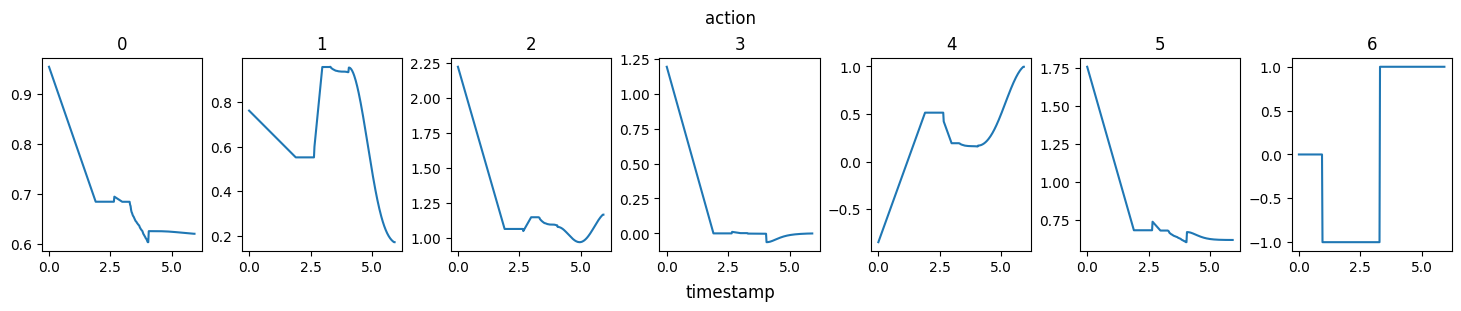

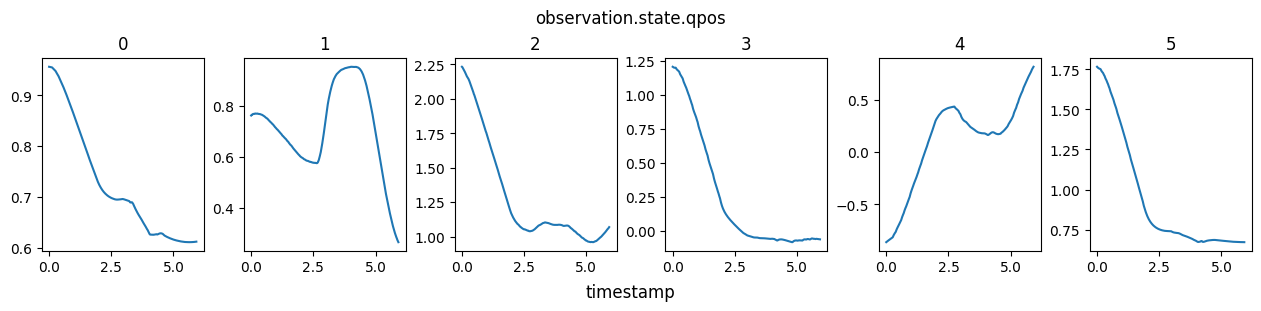

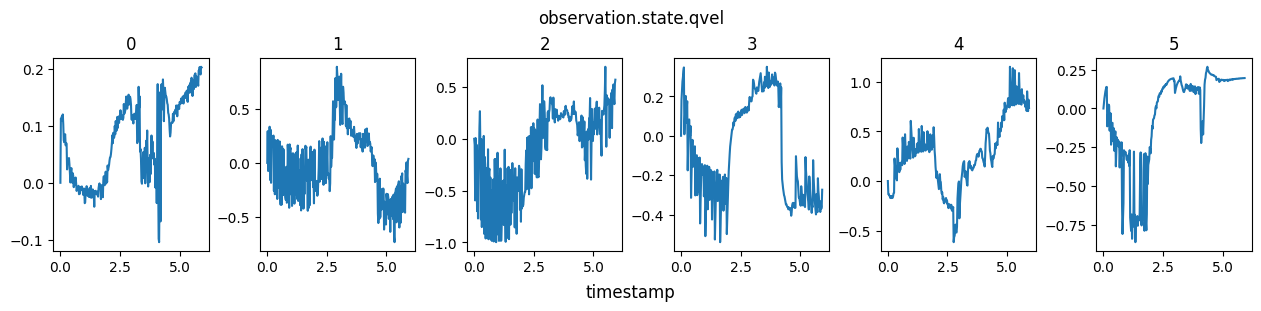

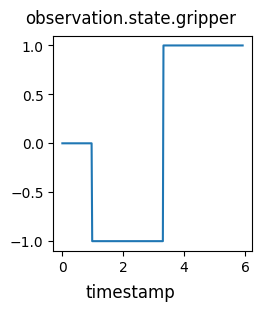

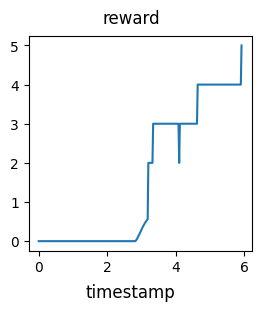

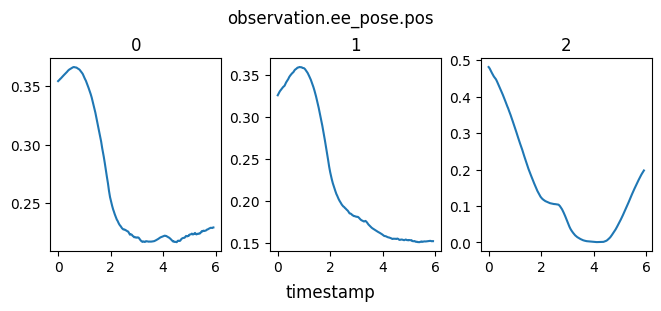

In [177]:
gym_lite6.utils.plot_dict_of_arrays(dataset.hf_dataset[from_idx:to_idx], "timestamp", keys=["action", "observation.state.qpos", "observation.state.qvel", "observation.state.gripper", "reward", "observation.ee_pose.pos"], sharey=False)


# 3. Train policy

In [ ]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from operator import add
import torch

delta_timestamps = {
    # Load the previous image and state at -0.1 seconds before current frame,
    # then load current image and state corresponding to 0.0 second.
    "observation.state": [-0.096, 0.0],
    # "observation.state.qpos": [-0.096, 0.0],
    "observation.images.gripper": [-0.096, 0.0],
    "observation.images.side": [-0.096, 0.0],
    # Load the previous action (-0.096), the next action to be executed (0.0),
    # and 14 future actions with a 0.096 seconds spacing. All these actions will be
    # used to supervise the policy.
    "action": [-0.096, 0.0, 0.096, 0.192, 0.288, 0.384, 0.512, 0.608, 0.704, 0.8, 0.896, 1.024, 1.12, 1.216, 1.312, 1.408],
    # "action.gripper": [-0.096, 0.0, 0.096, 0.192, 0.288, 0.384, 0.512, 0.608, 0.704, 0.8, 0.896, 1.024, 1.12, 1.216, 1.312, 1.408],
}

dataset_name = "grasp_and_lift_random_50_2024-09-18_16-52-04"
# may need to change the metadata fps to 31.25 and increase the tolerance
dataset = LeRobotDataset("eufrizz/" + dataset_name,root="datasets/" + dataset_name, local_files_only=True, delta_timestamps=delta_timestamps)

# from lerobot.common.datasets.utils import hf_transform_to_torch
# def transform(row):
#     # print(type(row["action.qpos"]))
#     if "observation.qpos" in row and "observation.gripper" in row:
#         row["observation"] = row["observation.qpos"] + row["observation.gripper"]
#     return hf_transform_to_torch(row)
# dataset.hf_dataset.set_transform(transform)

# We need to combine the qpos/qvel with gripper, to form one observation.state - the way diffusion is set up 
# input_features["observation.state"] = PolicyFeature(FeatureType.STATE, tuple(map(add, features['observation.state.qpos'].shape, features['observation.state.gripper'].shape)))
dataset.features["observation.state"] = {"dtype": dataset.features["observation.state.qpos"]["dtype"],
                                         "shape": tuple(map(add, dataset.features['observation.state.qpos']["shape"], dataset.features['observation.state.gripper']["shape"]))}

dataset.meta.stats['observation.state'] = {key: torch.hstack([dataset.meta.stats['observation.state.qpos'][key], dataset.meta.stats['observation.state.gripper'][key]]) for key in dataset.meta.stats['observation.state.qpos']}
def obs_col(x):
    x["observation.state"] = [torch.cat([x["observation.state.qpos"][i], x["observation.state.gripper"][i].unsqueeze(0)]) for i in range(len(x["observation.state.qpos"]))]
    return x
dataset.hf_dataset = dataset.hf_dataset.map(obs_col, batched=True)


Returning existing local_dir `datasets/grasp_and_lift_random_50_2024-09-18_16-52-04` as remote repo cannot be accessed in `snapshot_download` (None).
Returning existing local_dir `datasets/grasp_and_lift_random_50_2024-09-18_16-52-04` as remote repo cannot be accessed in `snapshot_download` (None).


Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from lerobot.common.datasets.utils import dataset_to_policy_features
from lerobot.common.policies.diffusion.configuration_diffusion import DiffusionConfig
from lerobot.common.policies.diffusion.modeling_diffusion import DiffusionPolicy
from lerobot.configs.types import DictLike, FeatureType, PolicyFeature

features = dataset_to_policy_features(dataset.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.VISUAL or key == "observation.state"}

cfg = DiffusionConfig(
    input_features=input_features,
    output_features=output_features,
    crop_shape=None
)
policy = DiffusionPolicy(cfg, dataset_stats=dataset.meta.stats)
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)

device = torch.device("cuda")
policy.to(device);


In [28]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=1,
    batch_size=1,
    shuffle=True,
    pin_memory=device != torch.device("cpu"),
    drop_last=True,
)

In [29]:
# import tracemalloc

# tracemalloc.start()
training_steps = 5000

step = 0
done = False
while not done:
    for batch in dataloader:
        # batch["observation.state"] = torch.cat([batch["observation.state.qpos"], batch["observation.state.gripper"].unsqueeze(2)], 2)
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        output_dict = policy.forward(batch)
        loss = output_dict["loss"]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()        

        if step % 250 == 0:
            print(f"step: {step} loss: {loss.item():.3f}")
        step += 1
        if step >= training_steps:
            done = True
            break
        # dataset.hf_dataset.clear_cache()
        
# snapshot = tracemalloc.take_snapshot()
# top_stats = snapshot.statistics('lineno')  # Get statistics by line number
# for stat in top_stats[:10]:  # Show top 10 memory allocations
#     print(stat)
# tracemalloc.stop()  # Stop tracing
policy.save_pretrained(f"ckpts/grasp_and_lift_diffusion_step_{step}")


step: 0 loss: 1.324
step: 250 loss: 0.530
step: 500 loss: 0.131
step: 750 loss: 0.309
step: 1000 loss: 0.172
step: 1250 loss: 0.063
step: 1500 loss: 0.062
step: 1750 loss: 0.170
step: 2000 loss: 0.032
step: 2250 loss: 0.131
step: 2500 loss: 0.122
step: 2750 loss: 0.102
step: 3000 loss: 0.059
step: 3250 loss: 0.072
step: 3500 loss: 0.069
step: 3750 loss: 0.073
step: 4000 loss: 0.013
step: 4250 loss: 0.097
step: 4500 loss: 0.030
step: 4750 loss: 0.048


# 4. Evaluate policy

In [32]:
from lerobot.common.policies.diffusion.modeling_diffusion import DiffusionPolicy
import torch
device = "cuda"
policy = DiffusionPolicy.from_pretrained("ckpts/grasp_and_lift_diffusion_step_5000").to(device)
policy.eval()

Loading weights from local directory


DiffusionPolicy(
  (normalize_inputs): Normalize(
    (buffer_observation_pixels_side): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
    )
    (buffer_observation_pixels_gripper): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
    )
    (buffer_observation_state): ParameterDict(
        (max): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
        (min): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
    )
  )
  (normalize_targets): Normalize(
    (buffer_action): ParameterDict(
        (max): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
        (min): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
    )
  )
  (unnormalize_outputs): U

In [33]:
observation, info = env.reset()

step = 0
done = False
images = [observation["pixels"]["side"]]
ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}

while not done:
    # start_loop_t = time.perf_counter()
    # print(idx - from_idx)
    # action = {"gripper": int(frame["action"][-1]), "qpos": frame["action"][:6]}
    # tuple(map(add, dataset.features['observation.state.qpos']["shape"], dataset.features['observation.state.gripper']["shape"]))
    observation["observation.state"] = torch.from_numpy(np.float32(np.hstack((observation["state"]["qpos"], observation["state"]["gripper"])))).unsqueeze(0).to(device)
    observation["observation.pixels.side"] = torch.from_numpy(observation['pixels']['side']).permute((2,0,1)).unsqueeze(0).to(device)/255
    observation["observation.pixels.gripper"] = torch.from_numpy(observation['pixels']['gripper']).permute((2,0,1)).unsqueeze(0).to(device)/255
    
    with torch.inference_mode():
        action = policy.select_action(observation).detach().cpu()[0]
    action = {"qpos": action[:env.unwrapped.dof], "gripper": round(action[-1].item())}
    
    observation, reward, terminated, truncated, info = env.step(action)
    images.append(observation["pixels"]["side"])

    ep_dict["action.qpos"].append(action["qpos"])
    ep_dict["action.gripper"].append(action["gripper"])
    ep_dict["observation.state.qpos"].append(observation["state"]["qpos"])
    ep_dict["observation.state.qvel"].append(observation["state"]["qvel"])
    ep_dict["observation.state.gripper"].append(observation["state"]["gripper"])
    ep_dict["observation.pixels.side"].append(observation["pixels"]["side"])
    ep_dict["observation.pixels.gripper"].append(observation["pixels"]["gripper"])
    ep_dict["reward"].append(reward)
    ep_dict["timestamp"].append(env.unwrapped.data.time)
    ep_dict["frame_index"].append(step)

    done = terminated | truncated | done
    step += 1
    # break

media.show_videos([images])
# action
# media.write_video("diffusion_step_1000.mp4", images)



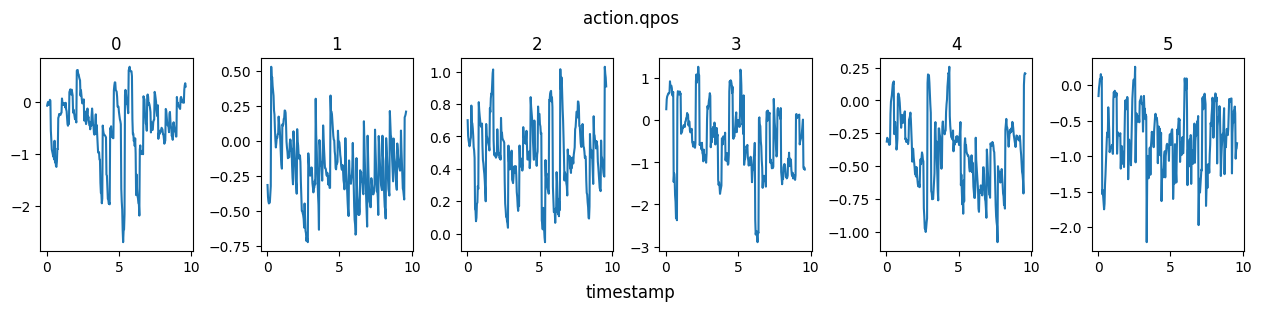

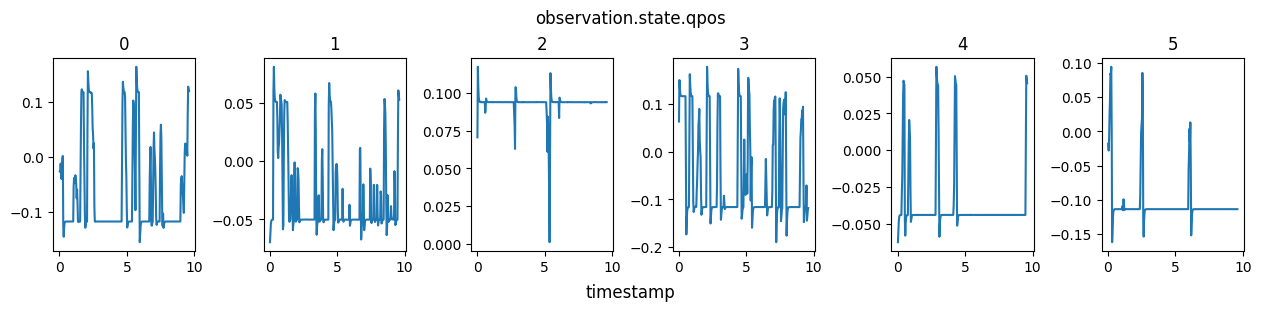

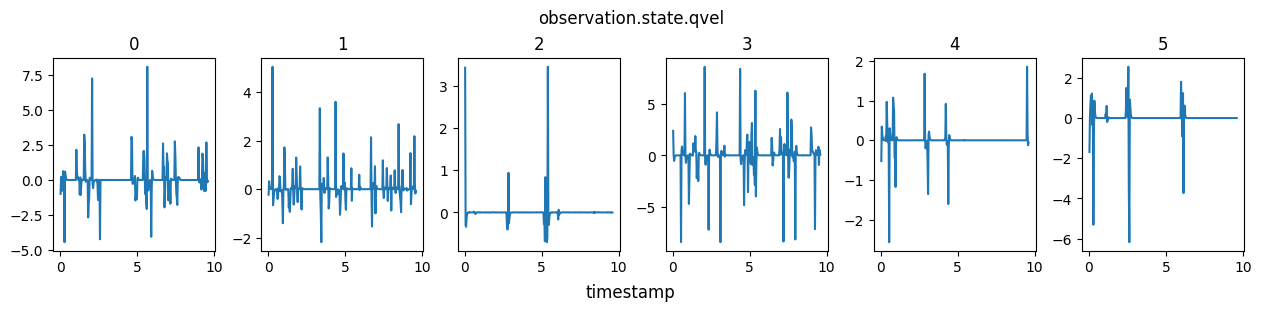

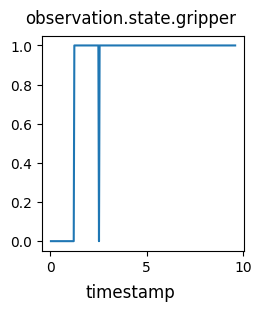

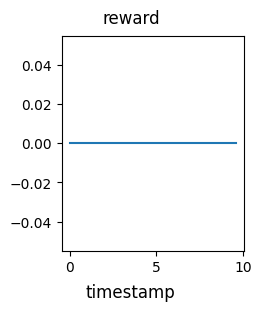

In [77]:
gym_lite6.utils.plot_dict_of_arrays(ep_dict, "timestamp", keys=["action.qpos", "observation.state.qpos", "observation.state.qvel", "observation.state.gripper", "reward"], sharey=False)


TODO:
- Logging during training
- Train for longer
- Compare to existing Lerobot robot arm envs to see what might be failing
- Is it a data issue?
- End effector velocity

# ACT


In [178]:
import torch
import lerobot
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from pprint import pprint
from lerobot.common.policies.act.modeling_act import ACTConfig, ACTPolicy, ACTTemporalEnsembler
from lerobot.common.envs.configs import AlohaEnv
from lerobot.common.datasets.utils import dataset_to_policy_features
from lerobot.configs.types import FeatureType
import mediapy as media
from lerobot.common.datasets.factory import make_dataset
import lerobot.common.envs.factory
import numpy as np

In [5]:

dataset_metadata = LeRobotDatasetMetadata("lerobot/aloha_sim_transfer_cube_scripted")
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

# Create TDMPC config
# cfg = TDMPCConfig(
#     input_features=input_features,
#     output_features=output_features,
#     # use_mpc=True,
# )
orig_cfg = ACTConfig(input_features=input_features, output_features=output_features)
# env = AlohaEnv(task="AlohaTransferCube-v0")


In [17]:
pprint(cfg)

ACTConfig(n_obs_steps=1,
          normalization_mapping={'ACTION': <NormalizationMode.MEAN_STD: 'MEAN_STD'>,
                                 'STATE': <NormalizationMode.MEAN_STD: 'MEAN_STD'>,
                                 'VISUAL': <NormalizationMode.MEAN_STD: 'MEAN_STD'>},
          input_features={'observation.images.top': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>,
                                                                  shape=(3,
                                                                         480,
                                                                         640)),
                          'observation.state': PolicyFeature(type=<FeatureType.STATE: 'STATE'>,
                                                             shape=(14,))},
          output_features={'action': PolicyFeature(type=<FeatureType.ACTION: 'ACTION'>,
                                                   shape=(14,))},
          device='cuda',
          use_amp=False,
       

In [ ]:
dataset_name = "lite6_record_scripted_250623_noisy"
dataset_metadata = LeRobotDatasetMetadata("eufrizz/" + dataset_name,root="datasets/" + dataset_name)
dataset_metadata

LeRobotDatasetMetadata({
    Repository ID: 'eufrizz/lite6_record_scripted_250622',
    Total episodes: '50',
    Total frames: '17918',
    Features: '['action', 'observation.state.qpos', 'observation.state.qvel', 'observation.state.gripper', 'observation.ee_pose.pos', 'observation.ee_pose.quat', 'observation.ee_pose.vel', 'observation.ee_pose.ang_vel', 'observation.images.gripper', 'observation.images.side', 'episode_index', 'frame_index', 'timestamp', 'reward', 'index', 'task_index']',
})',

In [183]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from operator import add
import torch

dataset_metadata = LeRobotDatasetMetadata("eufrizz/" + dataset_name,root="datasets/" + dataset_name)
# features = dataset_to_policy_features(dataset_metadata.features)
# output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
# # input_features = {key: ft for key, ft in features.items() if key not in output_features}
# input_features = {key: ft for key, ft in features.items() if key in ["observation.state"]}


delta_timestamps = {
    "action": [i / dataset_metadata.fps for i in ACTConfig().action_delta_indices],
    # "action": [0.0, 0.0],
}
print(delta_timestamps)

# may need to change the metadata fps to 31.25 and increase the tolerance
dataset = LeRobotDataset("eufrizz/" + dataset_name,root="datasets/" + dataset_name, delta_timestamps=delta_timestamps)

dataset.features["observation.state"] = {"dtype": dataset.features["observation.state.qpos"]["dtype"],
                                         "shape": tuple(map(add, dataset.features['observation.state.qpos']["shape"], dataset.features['observation.state.gripper']["shape"]))}

dataset.meta.stats['observation.state'] = {key: np.hstack([dataset.meta.stats['observation.state.qpos'][key], dataset.meta.stats['observation.state.gripper'][key]]) for key in dataset.meta.stats['observation.state.qpos']}
def obs_col(x):
    x["observation.state"] = [torch.cat([x["observation.state.qpos"][i], x["observation.state.gripper"][i].unsqueeze(0)]) for i in range(len(x["observation.state.qpos"]))]
    return x
dataset.hf_dataset = dataset.hf_dataset.map(obs_col, batched=True)

features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
# input_features = {key: ft for key, ft in features.items() if key not in output_features}
input_features = {key: ft for key, ft in features.items() if key in ["observation.state", "observation.images.side", "observation.images.gripper"]}


cfg = ACTConfig(input_features=input_features, output_features=output_features)

task = gym_lite6.pickup_task.GraspAndLiftTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')


device = "cuda" if torch.cuda.is_available() else "mps"
policy = ACTPolicy(cfg, dataset_metadata.stats)
policy.to(device)
policy.train()
step = 0



{'action': [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.14, 1.16, 1.18, 1.2, 1.22, 1.24, 1.26, 1.28, 1.3, 1.32, 1.34, 1.36, 1.38, 1.4, 1.42, 1.44, 1.46, 1.48, 1.5, 1.52, 1.54, 1.56, 1.58, 1.6, 1.62, 1.64, 1.66, 1.68, 1.7, 1.72, 1.74, 1.76, 1.78, 1.8, 1.82, 1.84, 1.86, 1.88, 1.9, 1.92, 1.94, 1.96, 1.98]}


Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

In [104]:
# cfg.output_features, cfg.input_features
reload(lerobot)

<module 'lerobot' from '/media/ssd/eugene/robotic_manipulation/lerobot/lerobot/__init__.py'>

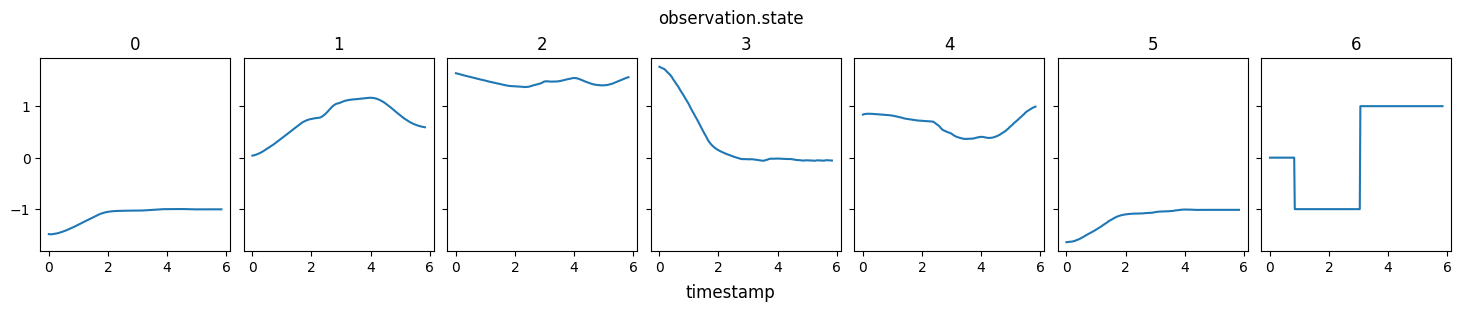

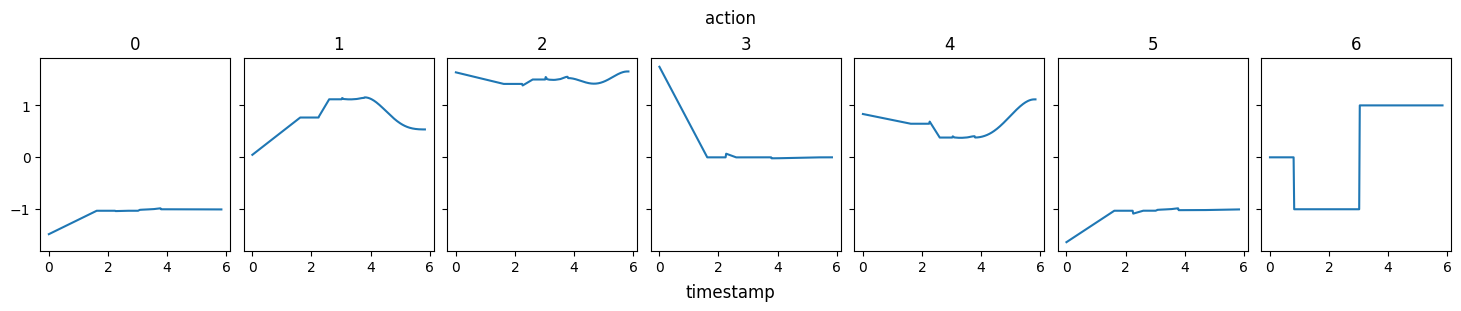

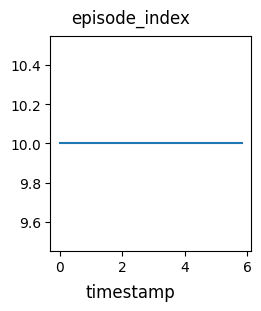

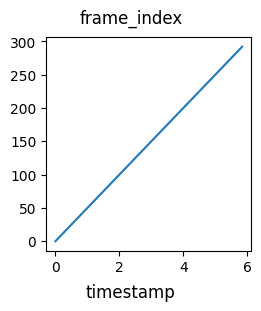

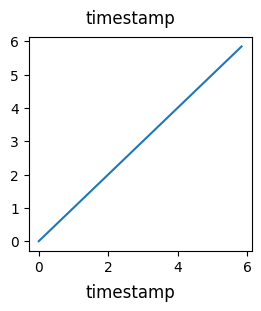

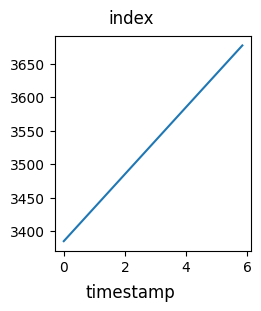

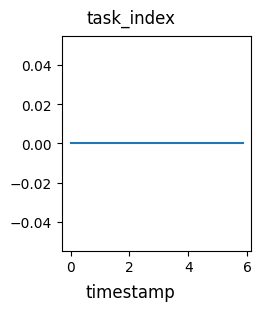

In [181]:
ep_idx = 10
from_idx = dataset.episode_data_index["from"][ep_idx].item()
to_idx = dataset.episode_data_index["to"][ep_idx].item()

env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=300,
    visualization_width=320,
    visualization_height=240
)

replay_frames = []
orig_frames = []
gripper_frames = []
action = {"gripper": int(dataset[from_idx]["action"][0][-1]), "qpos": dataset[from_idx]["action"][0][:6]}
observation, info = env.reset(qpos=action["qpos"])

for idx in range(from_idx, to_idx):
    frame = dataset[idx]
    action = {"gripper": int(frame["action"][0][-1]), "qpos": frame["action"][0][:6]}
    # action = {"gripper": data["action.gripper"], "qpos": data["action.qpos"]}
    # print(action)
    observation, reward, terminated, truncated, info = env.step(action)
    # print(observation)
    replay_frames.append(observation["pixels"]["side"])
    orig_frames.append(np.array(frame["observation.images.side"].permute(1,2,0)))
    gripper_frames.append(np.array(frame["observation.images.gripper"].permute(1,2,0)))
    # orig_frames.append(data["observation.pixels.side"])

media.show_videos([replay_frames, orig_frames, gripper_frames])

gym_lite6.utils.plot_dict_of_arrays(dataset.hf_dataset[from_idx:to_idx], "timestamp", ["observation.state", 'action', 'episode_index', 'frame_index', 'timestamp', 'index', 'task_index'])



In [184]:
optim_params = policy.get_optim_params() # if cfg.use_policy_training_preset else policy.parameters()
# policy.get_optimizer_preset()
# scheduler = cfg.get_scheduler_preset().build(optim_params)
optimizer = cfg.get_optimizer_preset().build(optim_params)


In [185]:

dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=1,
    batch_size=64,
    shuffle=False, # TODO: shuffle or not?
    pin_memory=device != "cpu",
    drop_last=True,
)
print(f"pin memory:{dataloader.pin_memory}")

pin memory:True


In [186]:
dataset_name

'lite6_record_scripted_250622'

```
{'batch_size': 8,
 'dataset': {'episodes': None,
             'image_transforms': {'enable': False,
                                  'max_num_transforms': 3,
                                  'random_order': False,
                                  'tfs': {'brightness': {'kwargs': {'brightness': [0.8,
                                                                                   1.2]},
                                                         'type': 'ColorJitter',
                                                         'weight': 1.0},
                                          'contrast': {'kwargs': {'contrast': [0.8,
                                                                               1.2]},
                                                       'type': 'ColorJitter',
                                                       'weight': 1.0},
                                          'hue': {'kwargs': {'hue': [-0.05,
                                                                     0.05]},
                                                  'type': 'ColorJitter',
                                                  'weight': 1.0},
                                          'saturation': {'kwargs': {'saturation': [0.5,
                                                                                   1.5]},
                                                         'type': 'ColorJitter',
                                                         'weight': 1.0},
                                          'sharpness': {'kwargs': {'sharpness': [0.5,
                                                                                 1.5]},
                                                        'type': 'SharpnessJitter',
                                                        'weight': 1.0}}},
             'repo_id': 'lerobot/aloha_sim_transfer_cube_human',
             'revision': None,
             'root': None,
             'use_imagenet_stats': True,
             'video_backend': 'pyav'},
 'env': {'episode_length': 400,
         'features': {'action': {'shape': [14],
                                 'type': <FeatureType.ACTION: 'ACTION'>},
                      'agent_pos': {'shape': [14],
                                    'type': <FeatureType.STATE: 'STATE'>},
                      'pixels/top': {'shape': [480, 640, 3],
                                     'type': <FeatureType.VISUAL: 'VISUAL'>}},
         'features_map': {'action': 'action',
                          'agent_pos': 'observation.state',
                          'pixels/top': 'observation.images.top',
                          'top': 'observation.image.top'},
         'fps': 50,
         'obs_type': 'pixels_agent_pos',
         'render_mode': 'rgb_array',
         'task': 'AlohaTransferCube-v0',
         'type': 'aloha'},
 'eval': {'batch_size': 50, 'n_episodes': 50, 'use_async_envs': False},
 'eval_freq': 20000,
 'job_name': 'aloha_act',
 'log_freq': 200,
 'num_workers': 4,
 'optimizer': {'betas': [0.9, 0.999],
               'eps': 1e-08,
               'grad_clip_norm': 10.0,
               'lr': 1e-05,
               'type': 'adamw',
               'weight_decay': 0.0001},
 'output_dir': 'outputs/train/act_aloha_transfer',
 'policy': {'chunk_size': 100,
            'device': 'cuda',
            'dim_feedforward': 3200,
            'dim_model': 512,
            'dropout': 0.1,
            'feedforward_activation': 'relu',
            'input_features': {},
            'kl_weight': 10.0,
            'latent_dim': 32,
            'n_action_steps': 100,
            'n_decoder_layers': 1,
            'n_encoder_layers': 4,
            'n_heads': 8,
            'n_obs_steps': 1,
            'n_vae_encoder_layers': 4,
            'normalization_mapping': {'ACTION': <NormalizationMode.MEAN_STD: 'MEAN_STD'>,
                                      'STATE': <NormalizationMode.MEAN_STD: 'MEAN_STD'>,
                                      'VISUAL': <NormalizationMode.MEAN_STD: 'MEAN_STD'>},
            'optimizer_lr': 1e-05,
            'optimizer_lr_backbone': 1e-05,
            'optimizer_weight_decay': 0.0001,
            'output_features': {},
            'pre_norm': False,
            'pretrained_backbone_weights': 'ResNet18_Weights.IMAGENET1K_V1',
            'replace_final_stride_with_dilation': False,
            'temporal_ensemble_coeff': None,
            'type': 'act',
            'use_amp': False,
            'use_vae': True,
            'vision_backbone': 'resnet18'},
 'resume': False,
 'save_checkpoint': True,
 'save_freq': 20000,
 'scheduler': None,
 'seed': 1000,
 'steps': 100000,
 'use_policy_training_preset': True,
 'wandb': {'disable_artifact': False,
           'enable': False,
           'entity': None,
           'notes': None,
           'project': 'lerobot'}}
```

In [187]:
import matplotlib.pyplot as plt

def eval(policy, env):
    policy.reset()
    policy.eval()
    numpy_observation, info = env.reset()
    rewards = []
    frames = [numpy_observation["pixels"]["side"].squeeze()]
    done = False
    observation = {}
    plt.close('all')

    ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.images.side": [], "observation.images.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}
    while not done:
        observation["observation.state"] = torch.from_numpy(np.float32(np.hstack((numpy_observation["state"]["qpos"], numpy_observation["state"]["gripper"])))).unsqueeze(0).to(device)
        # DIVIDE BY 255
        observation["observation.images.side"] = torch.from_numpy(numpy_observation['pixels']['side']).permute((2,0,1)).unsqueeze(0).to(device)/255
        observation["observation.images.gripper"] = torch.from_numpy(numpy_observation['pixels']['gripper']).permute((2,0,1)).unsqueeze(0).to(device)/255

        with torch.inference_mode():
            action = policy.select_action(observation).detach().cpu()[0]
        action = {"qpos": action[:env.unwrapped.dof], "gripper": round(np.clip(action[-1].item(), -1, 1))}
        numpy_observation, reward, terminated, truncated, info = env.step(action)

        rewards.append(reward)
        frames.append(numpy_observation["pixels"]["side"].squeeze())

        ep_dict["action.qpos"].append(action["qpos"])
        ep_dict["action.gripper"].append(action["gripper"])
        ep_dict["observation.state.qpos"].append(numpy_observation["state"]["qpos"])
        ep_dict["observation.state.qvel"].append(numpy_observation["state"]["qvel"])
        ep_dict["observation.state.gripper"].append(numpy_observation["state"]["gripper"])
        ep_dict["observation.images.side"].append(numpy_observation["pixels"]["side"])
        ep_dict["observation.images.gripper"].append(numpy_observation["pixels"]["gripper"])
        ep_dict["reward"].append(reward)
        ep_dict["timestamp"].append(env.unwrapped.data.time)
        ep_dict["frame_index"].append(step)

        done = terminated | truncated

    print(f"Avg reward: {np.mean(ep_dict['reward'])}")
    media.show_video(frames, width=400)
    gym_lite6.utils.plot_dict_of_arrays(ep_dict, "timestamp", keys=["action.qpos", "observation.state.qpos", "observation.state.qvel", "observation.state.gripper", "reward"], sharey=False)

In [188]:
task = gym_lite6.pickup_task.GraspAndLiftTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')
env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=500,
    visualization_width=320,
    visualization_height=240
)

In [ ]:


from torch.utils.tensorboard import SummaryWriter
import time
import datetime

curr_time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
writer = SummaryWriter(log_dir=f"runs/lite6_grasp/{dataset_name}_{curr_time}")
policy.train()

num_steps = 50000
dl_iter = iter(dataloader)
end = time.time()
for _ in range(step, num_steps):
    data_load_time = time.time()
    try:
        batch = next(dl_iter)
    except StopIteration:
        dl_iter = iter(dataloader)
        batch = next(dl_iter)
    
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch[key] = batch[key].to(device, non_blocking=True)
    gpu_load_time = time.time()
    
    loss, output_dict = policy.forward(batch)
    pred_time = time.time()
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_time = time.time()

    writer.add_scalar("Loss/train", loss.item(), step)
    writer.add_scalar("Time/data_load", data_load_time - end, step)
    writer.add_scalar("Time/gpu_transfer", gpu_load_time - data_load_time, step)
    writer.add_scalar("Time/pred_time", pred_time - gpu_load_time, step)
    writer.add_scalar("Time/train_time", train_time - pred_time, step)
    writer.add_scalar("Time/step_time", time.time() - end, step)

    if step % 250 == 0:
        print(f"step: {step} loss: {loss.item():.3f}")
    if step % 1000 == 0:
        policy.save_pretrained(f"ckpts/act_lite6_{dataset_name}_step_{step}")
    if step % 2000 == 0:
        print(f"Eval step {step}:")
        eval(policy, env)
        policy.train()
    step += 1
    end = time.time()

policy.save_pretrained(f"ckpts/act_lite6_{dataset_name}_step_{step}")


In [ ]:

device = "cuda" if torch.cuda.is_available() else "mps"
step = 18000
policy = ACTPolicy.from_pretrained(f"ckpts/act_lite6_lite6_record_scripted_250416_step_{step}")
if 'temporal_ensembler' not in dir(policy):
    print("adding temporal ensembler")
    policy.config.n_action_steps = 1
    policy.config.temporal_ensemble_coeff = 0.01
    policy.temporal_ensembler = ACTTemporalEnsembler(policy.config.temporal_ensemble_coeff, policy.config.chunk_size)
policy.to(device)
policy.eval();

Loading weights from local directory
adding temporal ensembler


ACTPolicy(
  (normalize_inputs): Normalize(
    (buffer_observation_images_gripper): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
    )
    (buffer_observation_images_side): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
    )
  )
  (normalize_targets): Normalize(
    (buffer_action): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
    )
  )
  (unnormalize_outputs): Unnormalize(
    (buffer_action): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
    )
  )

Avg reward: 0.0737328249786003


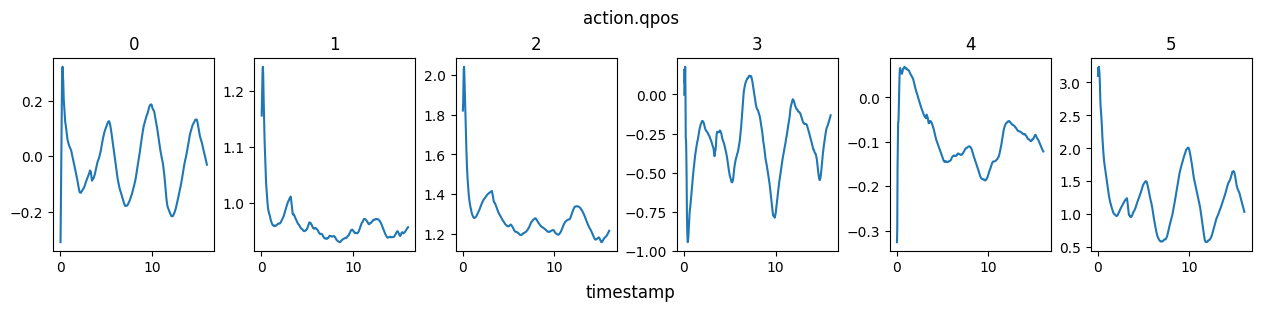

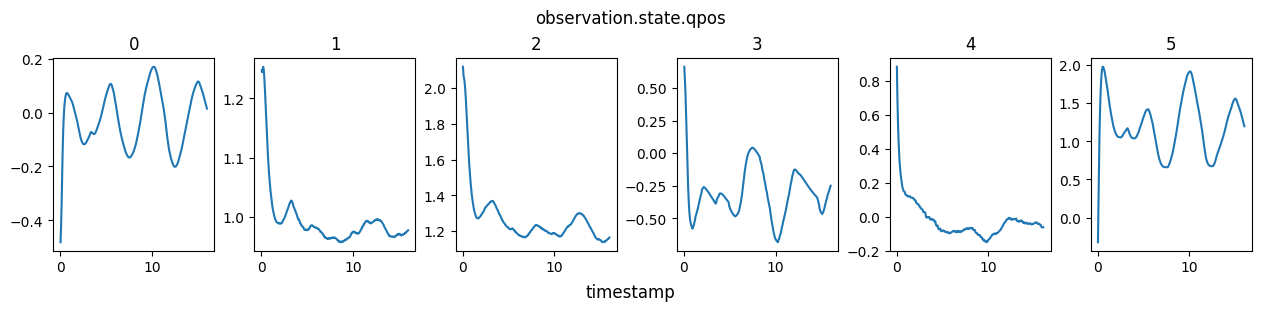

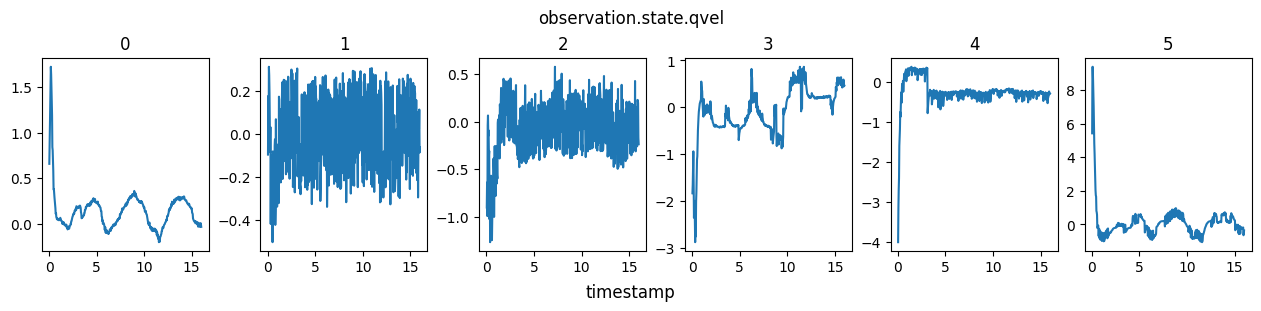

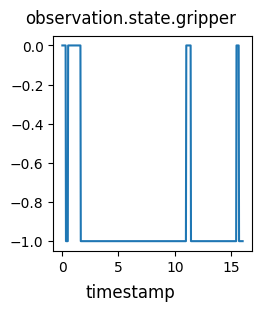

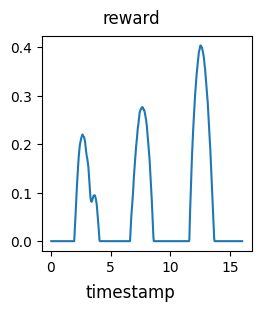

In [194]:
eval(policy, env)

In [12]:
observation.keys()

dict_keys(['observation.state', 'observation.images.side'])

In [19]:
policy.config.image_features

{'observation.images.side': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 240, 320))}

In [195]:
env.data.qfrc_applied

/media/ssd/eugene/robotic_manipulation/lerobot_venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.data to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.data` for environment variables or `env.get_wrapper_attr('data')` that will search the reminding wrappers.
  logger.warn(


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])